# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

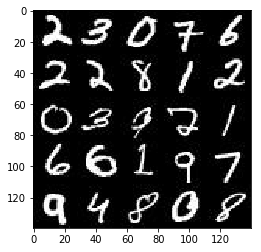

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

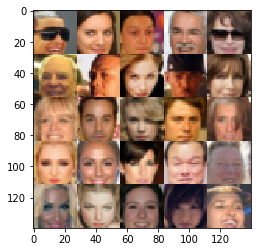

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images")
    input_zs = tf.placeholder(tf.float32, (None, z_dim), name='input_zs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    #return inputs_real, inputs_z
    return input_images, input_zs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha=0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_images, input_zs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, input_zs, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    n_step=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                n_step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_zs: batch_z, lr: learning_rate})
                
                if n_step % 100 == 0:
                    show_generator_output(sess, 25, input_zs, data_shape[3], data_image_mode)
                
                if n_step % 20 == 0:                    
                    train_loss_d = d_loss.eval({input_zs: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_zs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0529... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.9716... Generator Loss: 0.3182
Epoch 1/2... Discriminator Loss: 1.8927... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.8539... Generator Loss: 0.3075


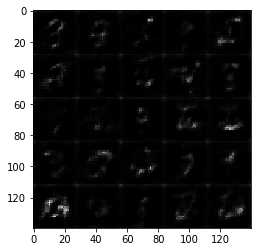

Epoch 1/2... Discriminator Loss: 1.7242... Generator Loss: 0.3696
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.9978... Generator Loss: 0.2669
Epoch 1/2... Discriminator Loss: 1.8254... Generator Loss: 0.5541
Epoch 1/2... Discriminator Loss: 1.7294... Generator Loss: 0.3635


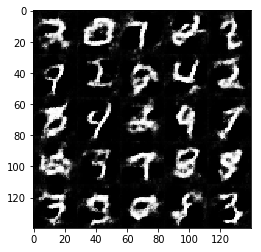

Epoch 1/2... Discriminator Loss: 1.5577... Generator Loss: 0.5081
Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.6123
Epoch 1/2... Discriminator Loss: 1.6981... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.6383


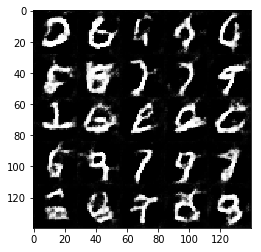

Epoch 1/2... Discriminator Loss: 1.6995... Generator Loss: 0.3548
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.4818
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.5507
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5886


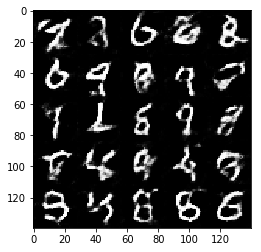

Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.8212
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.8690
Epoch 1/2... Discriminator Loss: 1.7714... Generator Loss: 0.3324


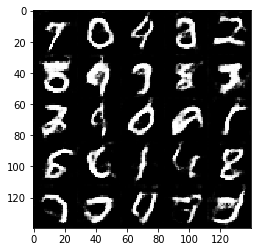

Epoch 1/2... Discriminator Loss: 1.5933... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.6229
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.7572


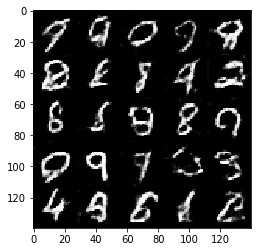

Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.4000
Epoch 1/2... Discriminator Loss: 1.5518... Generator Loss: 0.4735
Epoch 1/2... Discriminator Loss: 1.6161... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.6548


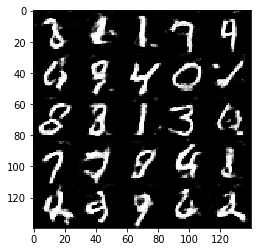

Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.5313... Generator Loss: 0.4836
Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.3805
Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 1.0228


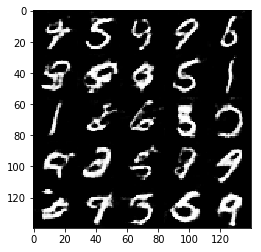

Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 1.3600
Epoch 1/2... Discriminator Loss: 1.8073... Generator Loss: 0.2954
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 1.0961
Epoch 1/2... Discriminator Loss: 2.3382... Generator Loss: 0.1743


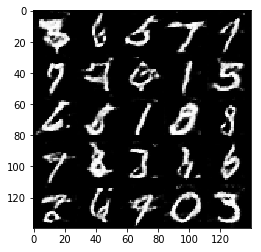

Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.5678... Generator Loss: 0.5231
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7015


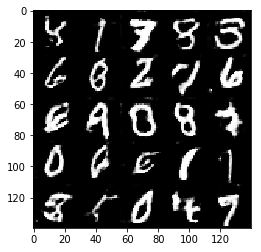

Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.9137... Generator Loss: 0.2680
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.7810


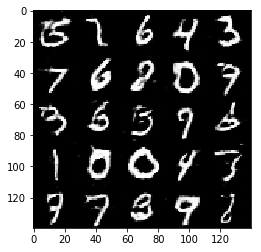

Epoch 2/2... Discriminator Loss: 1.7262... Generator Loss: 0.3293
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.5949
Epoch 2/2... Discriminator Loss: 1.7087... Generator Loss: 0.4466
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 1.1885


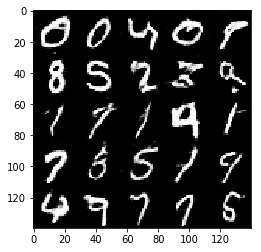

Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 1.1229
Epoch 2/2... Discriminator Loss: 1.5314... Generator Loss: 0.5234
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.4163
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 0.6408


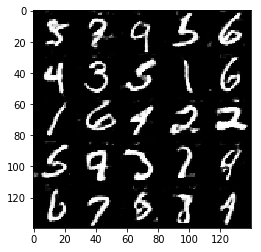

Epoch 2/2... Discriminator Loss: 2.0154... Generator Loss: 0.2406
Epoch 2/2... Discriminator Loss: 1.7629... Generator Loss: 0.3235
Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.5145
Epoch 2/2... Discriminator Loss: 1.6240... Generator Loss: 0.4041


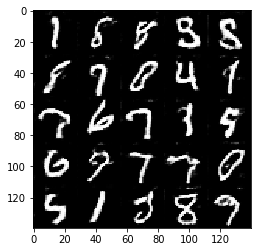

Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.8734... Generator Loss: 0.2975


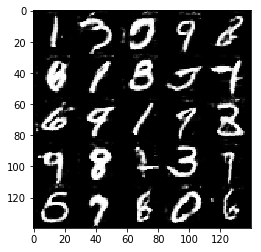

Epoch 2/2... Discriminator Loss: 2.0561... Generator Loss: 0.2281
Epoch 2/2... Discriminator Loss: 1.7755... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 1.7606... Generator Loss: 1.4638
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.7287


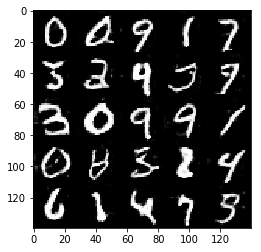

Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.5723... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.5679... Generator Loss: 0.4365
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.9382


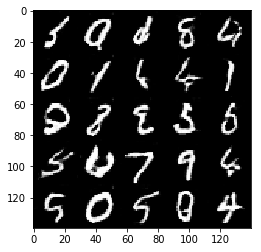

Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.6287
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.5909
Epoch 2/2... Discriminator Loss: 1.5329... Generator Loss: 0.4327
Epoch 2/2... Discriminator Loss: 1.6471... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 1.3246


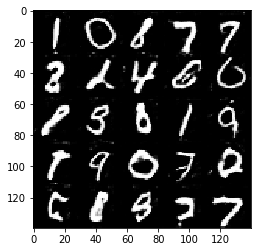

Epoch 2/2... Discriminator Loss: 1.5818... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.9467


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 3.4748... Generator Loss: 0.0591
Epoch 1/3... Discriminator Loss: 1.5902... Generator Loss: 0.5969
Epoch 1/3... Discriminator Loss: 1.5950... Generator Loss: 0.5574
Epoch 1/3... Discriminator Loss: 1.7087... Generator Loss: 0.5833


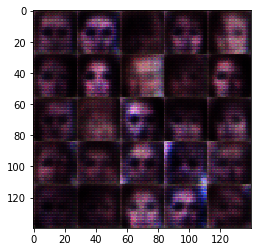

Epoch 1/3... Discriminator Loss: 1.7430... Generator Loss: 1.0333
Epoch 1/3... Discriminator Loss: 1.6773... Generator Loss: 0.5624
Epoch 1/3... Discriminator Loss: 1.6521... Generator Loss: 0.5058
Epoch 1/3... Discriminator Loss: 1.6513... Generator Loss: 0.5892
Epoch 1/3... Discriminator Loss: 1.7310... Generator Loss: 0.6068


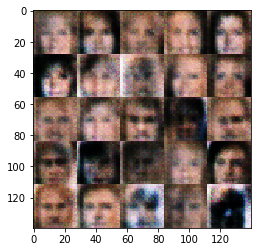

Epoch 1/3... Discriminator Loss: 1.5345... Generator Loss: 0.7153
Epoch 1/3... Discriminator Loss: 1.5193... Generator Loss: 0.6620
Epoch 1/3... Discriminator Loss: 1.6859... Generator Loss: 0.5504
Epoch 1/3... Discriminator Loss: 1.6171... Generator Loss: 0.6853
Epoch 1/3... Discriminator Loss: 1.5764... Generator Loss: 0.6735


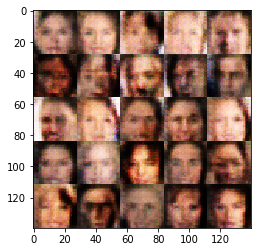

Epoch 1/3... Discriminator Loss: 1.4295... Generator Loss: 0.8000
Epoch 1/3... Discriminator Loss: 1.6421... Generator Loss: 0.9043
Epoch 1/3... Discriminator Loss: 1.5715... Generator Loss: 0.6148
Epoch 1/3... Discriminator Loss: 1.6762... Generator Loss: 0.6043
Epoch 1/3... Discriminator Loss: 1.4474... Generator Loss: 0.9452


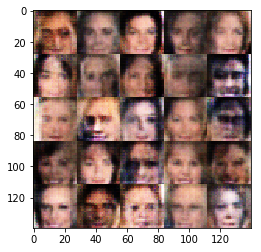

Epoch 1/3... Discriminator Loss: 1.5205... Generator Loss: 0.5988
Epoch 1/3... Discriminator Loss: 1.5336... Generator Loss: 0.6086
Epoch 1/3... Discriminator Loss: 1.5319... Generator Loss: 0.6380
Epoch 1/3... Discriminator Loss: 1.5874... Generator Loss: 0.6612
Epoch 1/3... Discriminator Loss: 1.4792... Generator Loss: 0.6801


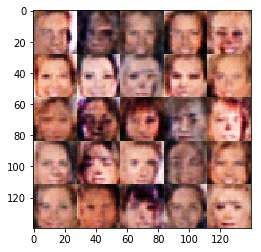

Epoch 1/3... Discriminator Loss: 1.4677... Generator Loss: 0.7103
Epoch 1/3... Discriminator Loss: 1.4592... Generator Loss: 0.7299
Epoch 1/3... Discriminator Loss: 1.4510... Generator Loss: 0.8555
Epoch 1/3... Discriminator Loss: 1.4918... Generator Loss: 0.7130
Epoch 1/3... Discriminator Loss: 1.4626... Generator Loss: 0.7865


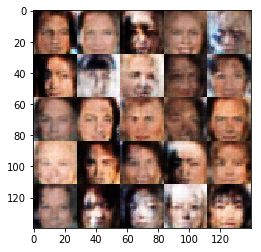

Epoch 1/3... Discriminator Loss: 1.4421... Generator Loss: 0.7436
Epoch 1/3... Discriminator Loss: 1.4905... Generator Loss: 0.6097
Epoch 1/3... Discriminator Loss: 1.4492... Generator Loss: 0.6748
Epoch 1/3... Discriminator Loss: 1.4879... Generator Loss: 0.6514
Epoch 1/3... Discriminator Loss: 1.4428... Generator Loss: 0.7639


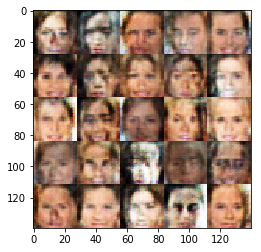

Epoch 1/3... Discriminator Loss: 1.4226... Generator Loss: 0.7602
Epoch 1/3... Discriminator Loss: 1.4377... Generator Loss: 0.7976
Epoch 1/3... Discriminator Loss: 1.4107... Generator Loss: 0.7592
Epoch 1/3... Discriminator Loss: 1.4206... Generator Loss: 0.6723
Epoch 1/3... Discriminator Loss: 1.4083... Generator Loss: 0.6858


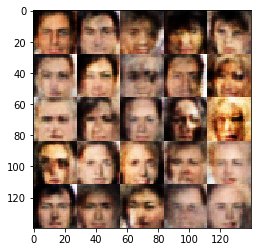

Epoch 1/3... Discriminator Loss: 1.4143... Generator Loss: 0.8038
Epoch 1/3... Discriminator Loss: 1.4331... Generator Loss: 0.7466
Epoch 1/3... Discriminator Loss: 1.3548... Generator Loss: 0.9474
Epoch 1/3... Discriminator Loss: 1.4229... Generator Loss: 0.7457
Epoch 1/3... Discriminator Loss: 1.4197... Generator Loss: 0.7767


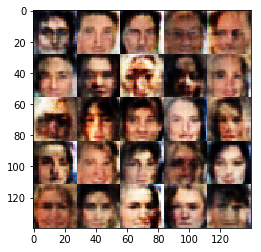

Epoch 1/3... Discriminator Loss: 1.4708... Generator Loss: 0.6797
Epoch 1/3... Discriminator Loss: 1.3791... Generator Loss: 0.6633
Epoch 1/3... Discriminator Loss: 1.4063... Generator Loss: 0.6457
Epoch 1/3... Discriminator Loss: 1.4344... Generator Loss: 0.7139
Epoch 1/3... Discriminator Loss: 1.5070... Generator Loss: 0.6572


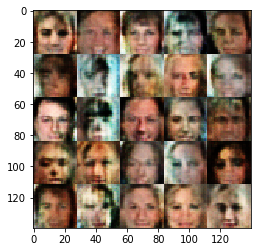

Epoch 1/3... Discriminator Loss: 1.4864... Generator Loss: 0.7191
Epoch 1/3... Discriminator Loss: 1.4730... Generator Loss: 0.5909
Epoch 1/3... Discriminator Loss: 1.3761... Generator Loss: 0.7142
Epoch 1/3... Discriminator Loss: 1.4566... Generator Loss: 0.6474
Epoch 1/3... Discriminator Loss: 1.4741... Generator Loss: 0.5891


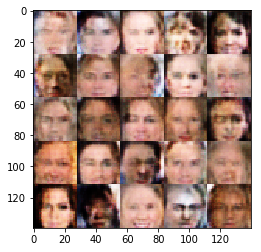

Epoch 1/3... Discriminator Loss: 1.4663... Generator Loss: 0.7120
Epoch 1/3... Discriminator Loss: 1.4086... Generator Loss: 0.8162
Epoch 1/3... Discriminator Loss: 1.4033... Generator Loss: 0.6896
Epoch 1/3... Discriminator Loss: 1.4419... Generator Loss: 0.6508
Epoch 1/3... Discriminator Loss: 1.4520... Generator Loss: 0.8867


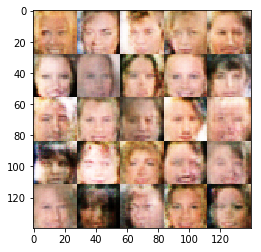

Epoch 1/3... Discriminator Loss: 1.4966... Generator Loss: 0.6295
Epoch 1/3... Discriminator Loss: 1.4913... Generator Loss: 0.7094
Epoch 1/3... Discriminator Loss: 1.4233... Generator Loss: 0.7353
Epoch 1/3... Discriminator Loss: 1.4321... Generator Loss: 0.7264
Epoch 1/3... Discriminator Loss: 1.4386... Generator Loss: 0.7577


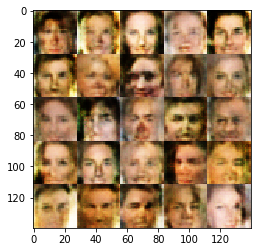

Epoch 1/3... Discriminator Loss: 1.4392... Generator Loss: 0.7951
Epoch 1/3... Discriminator Loss: 1.4881... Generator Loss: 0.7026
Epoch 1/3... Discriminator Loss: 1.4435... Generator Loss: 0.6390
Epoch 1/3... Discriminator Loss: 1.4107... Generator Loss: 0.7738
Epoch 1/3... Discriminator Loss: 1.5062... Generator Loss: 0.7203


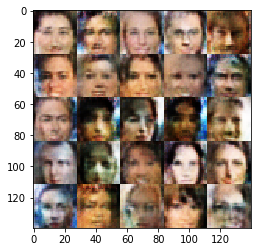

Epoch 1/3... Discriminator Loss: 1.4938... Generator Loss: 0.6811
Epoch 1/3... Discriminator Loss: 1.4726... Generator Loss: 0.7331
Epoch 1/3... Discriminator Loss: 1.4975... Generator Loss: 0.6684
Epoch 1/3... Discriminator Loss: 1.5416... Generator Loss: 0.6625
Epoch 1/3... Discriminator Loss: 1.4067... Generator Loss: 0.7326


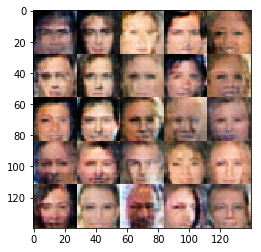

Epoch 1/3... Discriminator Loss: 1.4200... Generator Loss: 0.7818
Epoch 1/3... Discriminator Loss: 1.4430... Generator Loss: 0.7824
Epoch 1/3... Discriminator Loss: 1.4805... Generator Loss: 0.6274
Epoch 1/3... Discriminator Loss: 1.5237... Generator Loss: 0.5698
Epoch 1/3... Discriminator Loss: 1.4703... Generator Loss: 0.7051


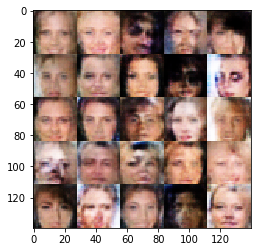

Epoch 1/3... Discriminator Loss: 1.4597... Generator Loss: 0.7026
Epoch 1/3... Discriminator Loss: 1.5180... Generator Loss: 0.6313
Epoch 1/3... Discriminator Loss: 1.4134... Generator Loss: 0.7265
Epoch 1/3... Discriminator Loss: 1.4752... Generator Loss: 0.6896
Epoch 1/3... Discriminator Loss: 1.4609... Generator Loss: 0.7633


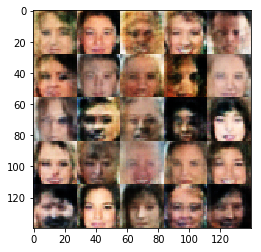

Epoch 1/3... Discriminator Loss: 1.4454... Generator Loss: 0.7119
Epoch 1/3... Discriminator Loss: 1.3955... Generator Loss: 0.7445
Epoch 1/3... Discriminator Loss: 1.4821... Generator Loss: 0.7427
Epoch 1/3... Discriminator Loss: 1.4676... Generator Loss: 0.7974
Epoch 1/3... Discriminator Loss: 1.5135... Generator Loss: 0.6276


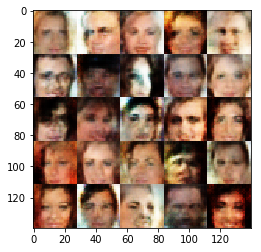

Epoch 1/3... Discriminator Loss: 1.4815... Generator Loss: 0.6509
Epoch 1/3... Discriminator Loss: 1.5088... Generator Loss: 0.6236
Epoch 1/3... Discriminator Loss: 1.4563... Generator Loss: 0.6915
Epoch 1/3... Discriminator Loss: 1.5295... Generator Loss: 0.6197
Epoch 1/3... Discriminator Loss: 1.4254... Generator Loss: 0.7571


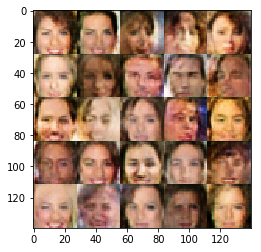

Epoch 1/3... Discriminator Loss: 1.4048... Generator Loss: 0.8878
Epoch 1/3... Discriminator Loss: 1.4738... Generator Loss: 0.6878
Epoch 1/3... Discriminator Loss: 1.4698... Generator Loss: 0.6544
Epoch 1/3... Discriminator Loss: 1.4883... Generator Loss: 0.6813
Epoch 1/3... Discriminator Loss: 1.4416... Generator Loss: 0.7678


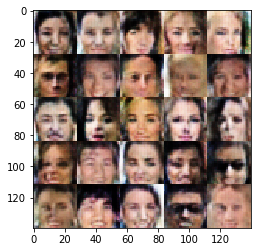

Epoch 1/3... Discriminator Loss: 1.4049... Generator Loss: 0.6743
Epoch 1/3... Discriminator Loss: 1.5011... Generator Loss: 0.6623
Epoch 1/3... Discriminator Loss: 1.4847... Generator Loss: 0.6439
Epoch 1/3... Discriminator Loss: 1.4532... Generator Loss: 0.6474
Epoch 1/3... Discriminator Loss: 1.4857... Generator Loss: 0.7430


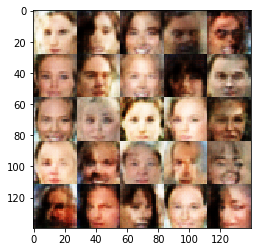

Epoch 1/3... Discriminator Loss: 1.5102... Generator Loss: 0.6693
Epoch 1/3... Discriminator Loss: 1.4643... Generator Loss: 0.7282
Epoch 1/3... Discriminator Loss: 1.4488... Generator Loss: 0.7142
Epoch 1/3... Discriminator Loss: 1.4228... Generator Loss: 0.6734
Epoch 1/3... Discriminator Loss: 1.4330... Generator Loss: 0.7815


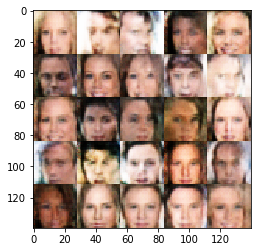

Epoch 1/3... Discriminator Loss: 1.4677... Generator Loss: 0.6918
Epoch 1/3... Discriminator Loss: 1.4480... Generator Loss: 0.6982
Epoch 1/3... Discriminator Loss: 1.4550... Generator Loss: 0.6133
Epoch 1/3... Discriminator Loss: 1.4201... Generator Loss: 0.7096
Epoch 1/3... Discriminator Loss: 1.4238... Generator Loss: 0.7963


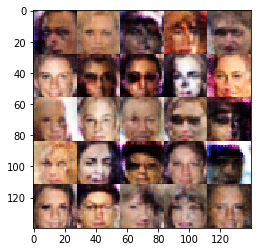

Epoch 1/3... Discriminator Loss: 1.5297... Generator Loss: 0.6010
Epoch 1/3... Discriminator Loss: 1.4540... Generator Loss: 0.6203
Epoch 1/3... Discriminator Loss: 1.4969... Generator Loss: 0.5693
Epoch 1/3... Discriminator Loss: 1.4589... Generator Loss: 0.6821
Epoch 1/3... Discriminator Loss: 1.4755... Generator Loss: 0.7044


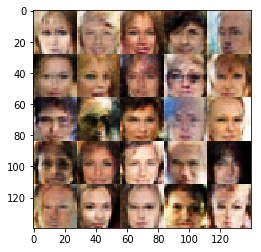

Epoch 1/3... Discriminator Loss: 1.4534... Generator Loss: 0.7007
Epoch 1/3... Discriminator Loss: 1.5128... Generator Loss: 0.6316
Epoch 1/3... Discriminator Loss: 1.4308... Generator Loss: 0.7315
Epoch 1/3... Discriminator Loss: 1.4738... Generator Loss: 0.7355
Epoch 1/3... Discriminator Loss: 1.4943... Generator Loss: 0.6367


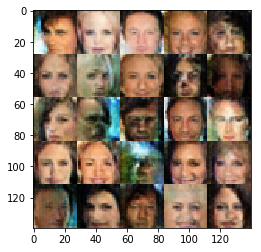

Epoch 1/3... Discriminator Loss: 1.5102... Generator Loss: 0.6499
Epoch 1/3... Discriminator Loss: 1.5464... Generator Loss: 0.6064
Epoch 1/3... Discriminator Loss: 1.4766... Generator Loss: 0.7273
Epoch 1/3... Discriminator Loss: 1.5199... Generator Loss: 0.6165
Epoch 1/3... Discriminator Loss: 1.4556... Generator Loss: 0.7215


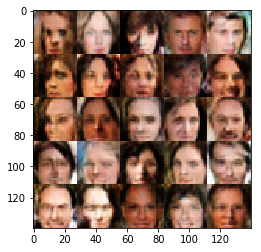

Epoch 1/3... Discriminator Loss: 1.4330... Generator Loss: 0.7557
Epoch 1/3... Discriminator Loss: 1.4757... Generator Loss: 0.6755
Epoch 1/3... Discriminator Loss: 1.4777... Generator Loss: 0.6573
Epoch 1/3... Discriminator Loss: 1.4845... Generator Loss: 0.7301
Epoch 1/3... Discriminator Loss: 1.5079... Generator Loss: 0.6979


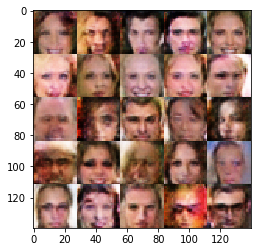

Epoch 1/3... Discriminator Loss: 1.4438... Generator Loss: 0.6630
Epoch 1/3... Discriminator Loss: 1.5371... Generator Loss: 0.5712
Epoch 1/3... Discriminator Loss: 1.5119... Generator Loss: 0.6848
Epoch 1/3... Discriminator Loss: 1.4703... Generator Loss: 0.7804
Epoch 1/3... Discriminator Loss: 1.5319... Generator Loss: 0.6670


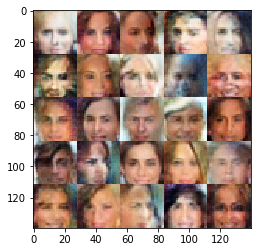

Epoch 1/3... Discriminator Loss: 1.4699... Generator Loss: 0.6541
Epoch 1/3... Discriminator Loss: 1.4475... Generator Loss: 0.6901
Epoch 1/3... Discriminator Loss: 1.4998... Generator Loss: 0.5880
Epoch 1/3... Discriminator Loss: 1.5386... Generator Loss: 0.7702
Epoch 1/3... Discriminator Loss: 1.4590... Generator Loss: 0.6143


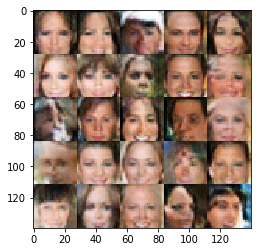

Epoch 1/3... Discriminator Loss: 1.4757... Generator Loss: 0.6438
Epoch 1/3... Discriminator Loss: 1.4936... Generator Loss: 0.6988
Epoch 1/3... Discriminator Loss: 1.3830... Generator Loss: 0.7640
Epoch 1/3... Discriminator Loss: 1.4593... Generator Loss: 0.7368
Epoch 1/3... Discriminator Loss: 1.4586... Generator Loss: 0.6679


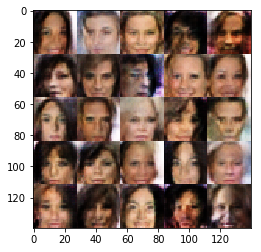

Epoch 1/3... Discriminator Loss: 1.4671... Generator Loss: 0.6523
Epoch 1/3... Discriminator Loss: 1.4362... Generator Loss: 0.6872
Epoch 1/3... Discriminator Loss: 1.4317... Generator Loss: 0.7212
Epoch 1/3... Discriminator Loss: 1.4821... Generator Loss: 0.7107
Epoch 1/3... Discriminator Loss: 1.4437... Generator Loss: 0.6625


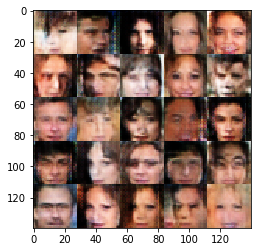

Epoch 1/3... Discriminator Loss: 1.4157... Generator Loss: 0.8050
Epoch 1/3... Discriminator Loss: 1.4127... Generator Loss: 0.7205
Epoch 1/3... Discriminator Loss: 1.5351... Generator Loss: 0.7464
Epoch 1/3... Discriminator Loss: 1.4355... Generator Loss: 0.6911
Epoch 2/3... Discriminator Loss: 1.4219... Generator Loss: 0.7608


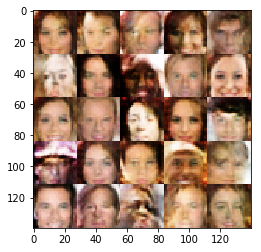

Epoch 2/3... Discriminator Loss: 1.4441... Generator Loss: 0.7586
Epoch 2/3... Discriminator Loss: 1.4564... Generator Loss: 0.7282
Epoch 2/3... Discriminator Loss: 1.4131... Generator Loss: 0.7765
Epoch 2/3... Discriminator Loss: 1.4789... Generator Loss: 0.6518
Epoch 2/3... Discriminator Loss: 1.4770... Generator Loss: 0.6158


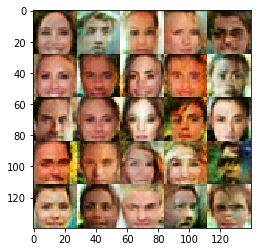

Epoch 2/3... Discriminator Loss: 1.4708... Generator Loss: 0.6601
Epoch 2/3... Discriminator Loss: 1.4973... Generator Loss: 0.6841
Epoch 2/3... Discriminator Loss: 1.4723... Generator Loss: 0.6310
Epoch 2/3... Discriminator Loss: 1.5018... Generator Loss: 0.5918
Epoch 2/3... Discriminator Loss: 1.4467... Generator Loss: 0.7227


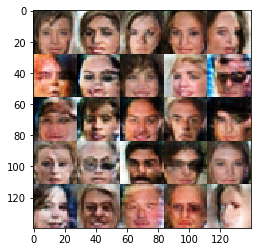

Epoch 2/3... Discriminator Loss: 1.4939... Generator Loss: 0.6807
Epoch 2/3... Discriminator Loss: 1.4383... Generator Loss: 0.6842
Epoch 2/3... Discriminator Loss: 1.4267... Generator Loss: 0.7142
Epoch 2/3... Discriminator Loss: 1.4380... Generator Loss: 0.6265
Epoch 2/3... Discriminator Loss: 1.4454... Generator Loss: 0.7127


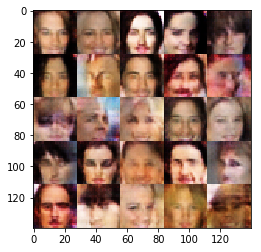

Epoch 2/3... Discriminator Loss: 1.4116... Generator Loss: 0.7143
Epoch 2/3... Discriminator Loss: 1.4720... Generator Loss: 0.7126
Epoch 2/3... Discriminator Loss: 1.4559... Generator Loss: 0.7193
Epoch 2/3... Discriminator Loss: 1.4268... Generator Loss: 0.7344
Epoch 2/3... Discriminator Loss: 1.4470... Generator Loss: 0.7109


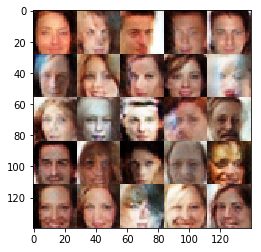

Epoch 2/3... Discriminator Loss: 1.4569... Generator Loss: 0.7406
Epoch 2/3... Discriminator Loss: 1.4349... Generator Loss: 0.7209
Epoch 2/3... Discriminator Loss: 1.4369... Generator Loss: 0.7458
Epoch 2/3... Discriminator Loss: 1.4608... Generator Loss: 0.6545
Epoch 2/3... Discriminator Loss: 1.4506... Generator Loss: 0.7150


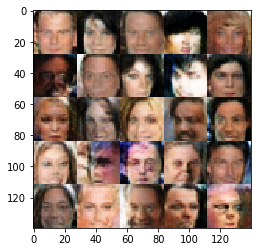

Epoch 2/3... Discriminator Loss: 1.4984... Generator Loss: 0.6764
Epoch 2/3... Discriminator Loss: 1.4276... Generator Loss: 0.7726
Epoch 2/3... Discriminator Loss: 1.4764... Generator Loss: 0.6902
Epoch 2/3... Discriminator Loss: 1.4748... Generator Loss: 0.6704
Epoch 2/3... Discriminator Loss: 1.4276... Generator Loss: 0.8103


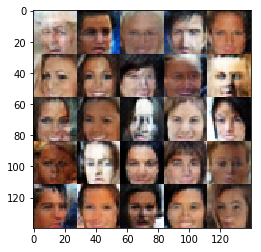

Epoch 2/3... Discriminator Loss: 1.4753... Generator Loss: 0.6892
Epoch 2/3... Discriminator Loss: 1.4273... Generator Loss: 0.7418
Epoch 2/3... Discriminator Loss: 1.4381... Generator Loss: 0.6258
Epoch 2/3... Discriminator Loss: 1.4684... Generator Loss: 0.6610
Epoch 2/3... Discriminator Loss: 1.4195... Generator Loss: 0.7242


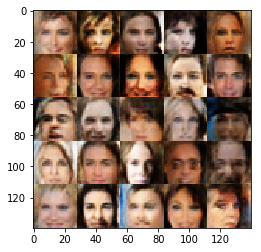

Epoch 2/3... Discriminator Loss: 1.4367... Generator Loss: 0.7544
Epoch 2/3... Discriminator Loss: 1.4851... Generator Loss: 0.7778
Epoch 2/3... Discriminator Loss: 1.4285... Generator Loss: 0.7386
Epoch 2/3... Discriminator Loss: 1.4118... Generator Loss: 0.7360
Epoch 2/3... Discriminator Loss: 1.4396... Generator Loss: 0.7190


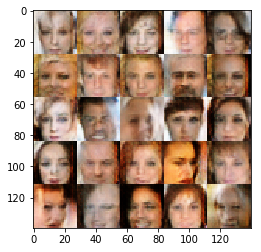

Epoch 2/3... Discriminator Loss: 1.4416... Generator Loss: 0.6902
Epoch 2/3... Discriminator Loss: 1.4504... Generator Loss: 0.7450
Epoch 2/3... Discriminator Loss: 1.4561... Generator Loss: 0.7258
Epoch 2/3... Discriminator Loss: 1.4404... Generator Loss: 0.7619
Epoch 2/3... Discriminator Loss: 1.4561... Generator Loss: 0.6221


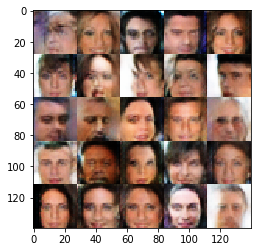

Epoch 2/3... Discriminator Loss: 1.4202... Generator Loss: 0.8803
Epoch 2/3... Discriminator Loss: 1.4216... Generator Loss: 0.7405
Epoch 2/3... Discriminator Loss: 1.4120... Generator Loss: 0.7409
Epoch 2/3... Discriminator Loss: 1.4444... Generator Loss: 0.6904
Epoch 2/3... Discriminator Loss: 1.4058... Generator Loss: 0.7884


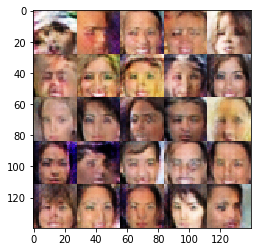

Epoch 2/3... Discriminator Loss: 1.4754... Generator Loss: 0.6961
Epoch 2/3... Discriminator Loss: 1.4370... Generator Loss: 0.8054
Epoch 2/3... Discriminator Loss: 1.4234... Generator Loss: 0.7062
Epoch 2/3... Discriminator Loss: 1.4516... Generator Loss: 0.7692
Epoch 2/3... Discriminator Loss: 1.4231... Generator Loss: 0.8667


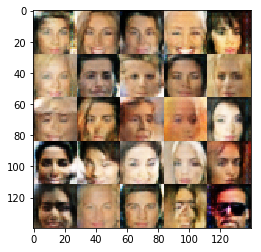

Epoch 2/3... Discriminator Loss: 1.4452... Generator Loss: 0.6822
Epoch 2/3... Discriminator Loss: 1.3398... Generator Loss: 0.8317
Epoch 2/3... Discriminator Loss: 1.4549... Generator Loss: 0.6996
Epoch 2/3... Discriminator Loss: 1.4225... Generator Loss: 0.8117
Epoch 2/3... Discriminator Loss: 1.4513... Generator Loss: 0.7456


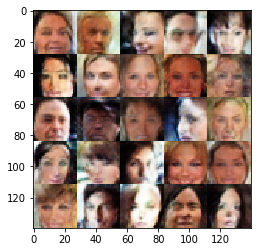

Epoch 2/3... Discriminator Loss: 1.4736... Generator Loss: 0.6437
Epoch 2/3... Discriminator Loss: 1.4634... Generator Loss: 0.6741
Epoch 2/3... Discriminator Loss: 1.4442... Generator Loss: 0.6334
Epoch 2/3... Discriminator Loss: 1.4420... Generator Loss: 0.6442
Epoch 2/3... Discriminator Loss: 1.4221... Generator Loss: 0.7063


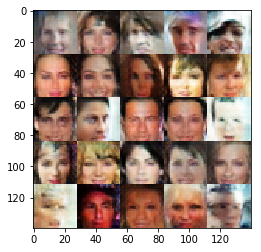

Epoch 2/3... Discriminator Loss: 1.4353... Generator Loss: 0.6969
Epoch 2/3... Discriminator Loss: 1.4635... Generator Loss: 0.6125
Epoch 2/3... Discriminator Loss: 1.4702... Generator Loss: 0.6615
Epoch 2/3... Discriminator Loss: 1.4578... Generator Loss: 0.6771
Epoch 2/3... Discriminator Loss: 1.4159... Generator Loss: 0.8092


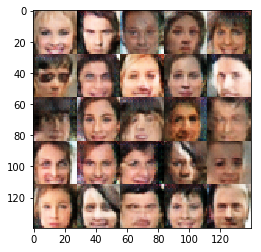

Epoch 2/3... Discriminator Loss: 1.4261... Generator Loss: 0.7007
Epoch 2/3... Discriminator Loss: 1.4616... Generator Loss: 0.6924
Epoch 2/3... Discriminator Loss: 1.4433... Generator Loss: 0.6926
Epoch 2/3... Discriminator Loss: 1.4203... Generator Loss: 0.7265
Epoch 2/3... Discriminator Loss: 1.4434... Generator Loss: 0.8172


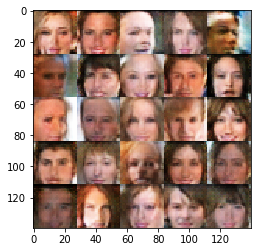

Epoch 2/3... Discriminator Loss: 1.4395... Generator Loss: 0.7718
Epoch 2/3... Discriminator Loss: 1.4445... Generator Loss: 0.7678
Epoch 2/3... Discriminator Loss: 1.4310... Generator Loss: 0.6882
Epoch 2/3... Discriminator Loss: 1.4755... Generator Loss: 0.6218
Epoch 2/3... Discriminator Loss: 1.4372... Generator Loss: 0.7381


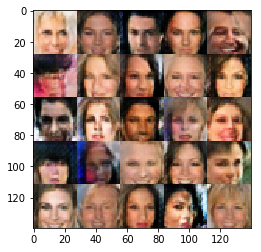

Epoch 2/3... Discriminator Loss: 1.4409... Generator Loss: 0.6490
Epoch 2/3... Discriminator Loss: 1.4023... Generator Loss: 0.7970
Epoch 2/3... Discriminator Loss: 1.4403... Generator Loss: 0.7158
Epoch 2/3... Discriminator Loss: 1.4559... Generator Loss: 0.7010
Epoch 2/3... Discriminator Loss: 1.4692... Generator Loss: 0.6500


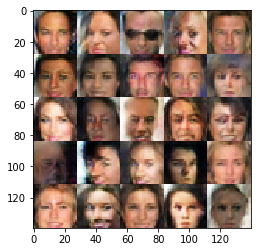

Epoch 2/3... Discriminator Loss: 1.4612... Generator Loss: 0.6620
Epoch 2/3... Discriminator Loss: 1.4679... Generator Loss: 0.6328
Epoch 2/3... Discriminator Loss: 1.4218... Generator Loss: 0.6931
Epoch 2/3... Discriminator Loss: 1.4581... Generator Loss: 0.7568
Epoch 2/3... Discriminator Loss: 1.4625... Generator Loss: 0.7095


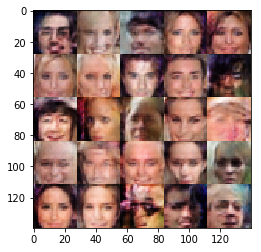

Epoch 2/3... Discriminator Loss: 1.4312... Generator Loss: 0.7423
Epoch 2/3... Discriminator Loss: 1.4738... Generator Loss: 0.7518
Epoch 2/3... Discriminator Loss: 1.4161... Generator Loss: 0.8326
Epoch 2/3... Discriminator Loss: 1.4269... Generator Loss: 0.7342
Epoch 2/3... Discriminator Loss: 1.4989... Generator Loss: 0.6236


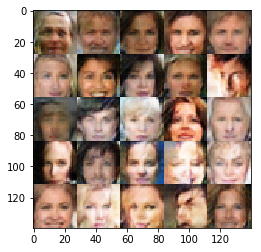

Epoch 2/3... Discriminator Loss: 1.4839... Generator Loss: 0.7083
Epoch 2/3... Discriminator Loss: 1.4060... Generator Loss: 0.7680
Epoch 2/3... Discriminator Loss: 1.4470... Generator Loss: 0.7135
Epoch 2/3... Discriminator Loss: 1.4453... Generator Loss: 0.6734
Epoch 2/3... Discriminator Loss: 1.4255... Generator Loss: 0.9166


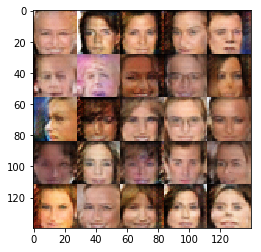

Epoch 2/3... Discriminator Loss: 1.4339... Generator Loss: 0.7647
Epoch 2/3... Discriminator Loss: 1.4520... Generator Loss: 0.7391
Epoch 2/3... Discriminator Loss: 1.4023... Generator Loss: 0.7528
Epoch 2/3... Discriminator Loss: 1.4543... Generator Loss: 0.6965
Epoch 2/3... Discriminator Loss: 1.4292... Generator Loss: 0.7859


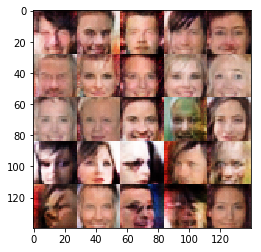

Epoch 2/3... Discriminator Loss: 1.4733... Generator Loss: 0.6903
Epoch 2/3... Discriminator Loss: 1.4012... Generator Loss: 0.7683
Epoch 2/3... Discriminator Loss: 1.4382... Generator Loss: 0.6402
Epoch 2/3... Discriminator Loss: 1.4383... Generator Loss: 0.7746
Epoch 2/3... Discriminator Loss: 1.4113... Generator Loss: 0.6559


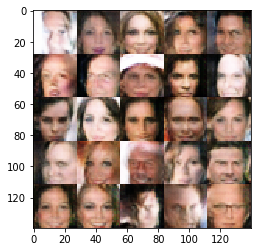

Epoch 2/3... Discriminator Loss: 1.4227... Generator Loss: 0.8011
Epoch 2/3... Discriminator Loss: 1.4216... Generator Loss: 0.8625
Epoch 2/3... Discriminator Loss: 1.4131... Generator Loss: 0.7087
Epoch 2/3... Discriminator Loss: 1.4281... Generator Loss: 0.6848
Epoch 2/3... Discriminator Loss: 1.5204... Generator Loss: 0.6431


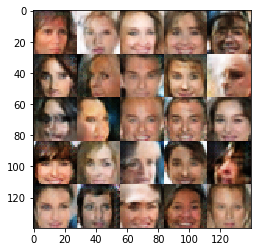

Epoch 2/3... Discriminator Loss: 1.4506... Generator Loss: 0.6926
Epoch 2/3... Discriminator Loss: 1.4234... Generator Loss: 0.7351
Epoch 2/3... Discriminator Loss: 1.4086... Generator Loss: 0.7612
Epoch 2/3... Discriminator Loss: 1.4192... Generator Loss: 0.7126
Epoch 2/3... Discriminator Loss: 1.4448... Generator Loss: 0.6570


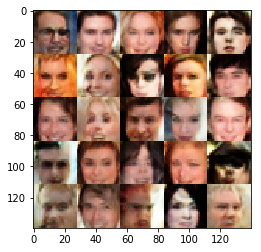

Epoch 2/3... Discriminator Loss: 1.4411... Generator Loss: 0.7254
Epoch 2/3... Discriminator Loss: 1.4193... Generator Loss: 0.7590
Epoch 2/3... Discriminator Loss: 1.4302... Generator Loss: 0.6805
Epoch 2/3... Discriminator Loss: 1.4201... Generator Loss: 0.7929
Epoch 2/3... Discriminator Loss: 1.4294... Generator Loss: 0.6917


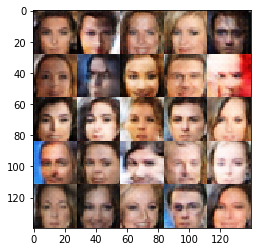

Epoch 2/3... Discriminator Loss: 1.4323... Generator Loss: 0.6373
Epoch 2/3... Discriminator Loss: 1.4311... Generator Loss: 0.7540
Epoch 2/3... Discriminator Loss: 1.3745... Generator Loss: 0.7815
Epoch 2/3... Discriminator Loss: 1.4282... Generator Loss: 0.7180
Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.7870


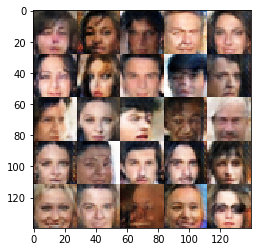

Epoch 2/3... Discriminator Loss: 1.4616... Generator Loss: 0.6321
Epoch 2/3... Discriminator Loss: 1.4089... Generator Loss: 0.8197
Epoch 2/3... Discriminator Loss: 1.4234... Generator Loss: 0.7179
Epoch 2/3... Discriminator Loss: 1.4714... Generator Loss: 0.7033
Epoch 2/3... Discriminator Loss: 1.4260... Generator Loss: 0.7308


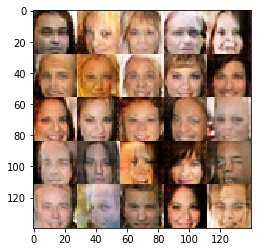

Epoch 2/3... Discriminator Loss: 1.4365... Generator Loss: 0.7902
Epoch 2/3... Discriminator Loss: 1.4323... Generator Loss: 0.7665
Epoch 2/3... Discriminator Loss: 1.4609... Generator Loss: 0.6620
Epoch 2/3... Discriminator Loss: 1.4250... Generator Loss: 0.7047
Epoch 2/3... Discriminator Loss: 1.4304... Generator Loss: 0.7493


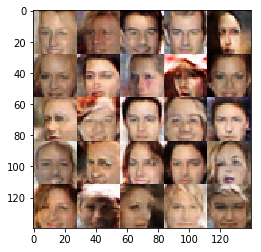

Epoch 2/3... Discriminator Loss: 1.4198... Generator Loss: 0.6886
Epoch 2/3... Discriminator Loss: 1.4423... Generator Loss: 0.6748
Epoch 2/3... Discriminator Loss: 1.4176... Generator Loss: 0.7600
Epoch 2/3... Discriminator Loss: 1.4352... Generator Loss: 0.7559
Epoch 2/3... Discriminator Loss: 1.4194... Generator Loss: 0.6890


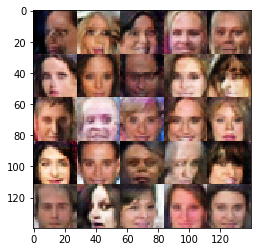

Epoch 2/3... Discriminator Loss: 1.4228... Generator Loss: 0.7390
Epoch 2/3... Discriminator Loss: 1.4135... Generator Loss: 0.7743
Epoch 2/3... Discriminator Loss: 1.4137... Generator Loss: 0.7387
Epoch 2/3... Discriminator Loss: 1.4202... Generator Loss: 0.7647
Epoch 2/3... Discriminator Loss: 1.4615... Generator Loss: 0.6804


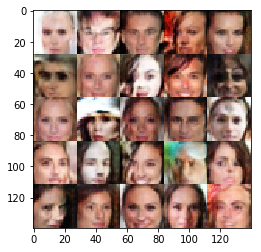

Epoch 2/3... Discriminator Loss: 1.4618... Generator Loss: 0.6347
Epoch 2/3... Discriminator Loss: 1.4157... Generator Loss: 0.6312
Epoch 2/3... Discriminator Loss: 1.4276... Generator Loss: 0.6706
Epoch 2/3... Discriminator Loss: 1.4500... Generator Loss: 0.6849
Epoch 2/3... Discriminator Loss: 1.4051... Generator Loss: 0.7227


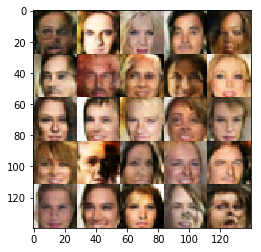

Epoch 2/3... Discriminator Loss: 1.4297... Generator Loss: 0.7436
Epoch 2/3... Discriminator Loss: 1.4753... Generator Loss: 0.7122
Epoch 3/3... Discriminator Loss: 1.4104... Generator Loss: 0.7690
Epoch 3/3... Discriminator Loss: 1.4493... Generator Loss: 0.7192
Epoch 3/3... Discriminator Loss: 1.4504... Generator Loss: 0.7150


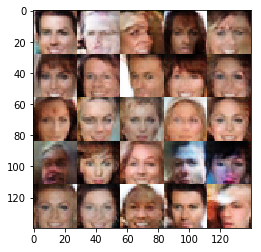

Epoch 3/3... Discriminator Loss: 1.4297... Generator Loss: 0.6824
Epoch 3/3... Discriminator Loss: 1.4344... Generator Loss: 0.7045
Epoch 3/3... Discriminator Loss: 1.4440... Generator Loss: 0.7003
Epoch 3/3... Discriminator Loss: 1.4345... Generator Loss: 0.7621
Epoch 3/3... Discriminator Loss: 1.4590... Generator Loss: 0.7206


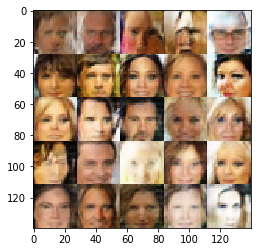

Epoch 3/3... Discriminator Loss: 1.4266... Generator Loss: 0.6470
Epoch 3/3... Discriminator Loss: 1.4416... Generator Loss: 0.6720
Epoch 3/3... Discriminator Loss: 1.4495... Generator Loss: 0.7751
Epoch 3/3... Discriminator Loss: 1.4040... Generator Loss: 0.8435
Epoch 3/3... Discriminator Loss: 1.4092... Generator Loss: 0.7512


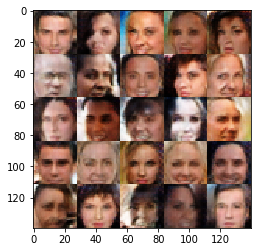

Epoch 3/3... Discriminator Loss: 1.3984... Generator Loss: 0.7957
Epoch 3/3... Discriminator Loss: 1.4168... Generator Loss: 0.7241
Epoch 3/3... Discriminator Loss: 1.4287... Generator Loss: 0.7455
Epoch 3/3... Discriminator Loss: 1.4024... Generator Loss: 0.7845
Epoch 3/3... Discriminator Loss: 1.4390... Generator Loss: 0.6695


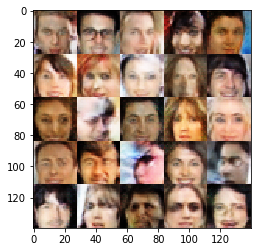

Epoch 3/3... Discriminator Loss: 1.4707... Generator Loss: 0.6958
Epoch 3/3... Discriminator Loss: 1.4581... Generator Loss: 0.6631
Epoch 3/3... Discriminator Loss: 1.4317... Generator Loss: 0.7369
Epoch 3/3... Discriminator Loss: 1.4468... Generator Loss: 0.6676
Epoch 3/3... Discriminator Loss: 1.4146... Generator Loss: 0.7047


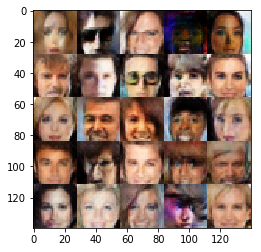

Epoch 3/3... Discriminator Loss: 1.4209... Generator Loss: 0.8056
Epoch 3/3... Discriminator Loss: 1.4746... Generator Loss: 0.6390
Epoch 3/3... Discriminator Loss: 1.4045... Generator Loss: 0.7026
Epoch 3/3... Discriminator Loss: 1.3802... Generator Loss: 0.7787
Epoch 3/3... Discriminator Loss: 1.4472... Generator Loss: 0.7212


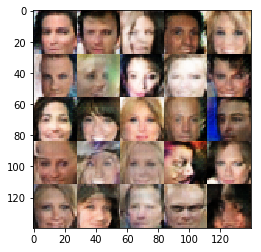

Epoch 3/3... Discriminator Loss: 1.4243... Generator Loss: 0.7456
Epoch 3/3... Discriminator Loss: 1.4477... Generator Loss: 0.6617
Epoch 3/3... Discriminator Loss: 1.4092... Generator Loss: 0.7428
Epoch 3/3... Discriminator Loss: 1.4166... Generator Loss: 0.7421
Epoch 3/3... Discriminator Loss: 1.4004... Generator Loss: 0.7443


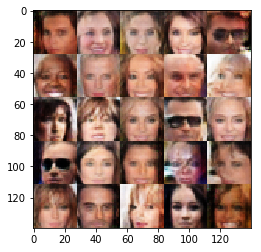

Epoch 3/3... Discriminator Loss: 1.4395... Generator Loss: 0.8281
Epoch 3/3... Discriminator Loss: 1.4509... Generator Loss: 0.6893
Epoch 3/3... Discriminator Loss: 1.4064... Generator Loss: 0.8088
Epoch 3/3... Discriminator Loss: 1.4426... Generator Loss: 0.6945
Epoch 3/3... Discriminator Loss: 1.4945... Generator Loss: 0.6959


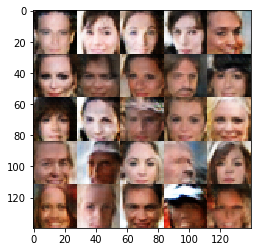

Epoch 3/3... Discriminator Loss: 1.4727... Generator Loss: 0.7006
Epoch 3/3... Discriminator Loss: 1.4052... Generator Loss: 0.7684
Epoch 3/3... Discriminator Loss: 1.4338... Generator Loss: 0.7089
Epoch 3/3... Discriminator Loss: 1.4257... Generator Loss: 0.7061
Epoch 3/3... Discriminator Loss: 1.4420... Generator Loss: 0.6454


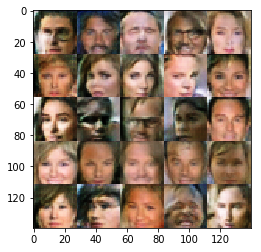

Epoch 3/3... Discriminator Loss: 1.4200... Generator Loss: 0.6918
Epoch 3/3... Discriminator Loss: 1.4499... Generator Loss: 0.7553
Epoch 3/3... Discriminator Loss: 1.4135... Generator Loss: 0.7643
Epoch 3/3... Discriminator Loss: 1.4560... Generator Loss: 0.7270
Epoch 3/3... Discriminator Loss: 1.3988... Generator Loss: 0.8854


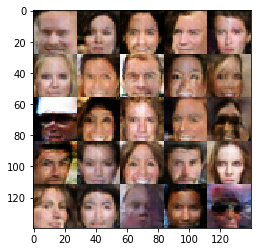

Epoch 3/3... Discriminator Loss: 1.3979... Generator Loss: 0.6673
Epoch 3/3... Discriminator Loss: 1.4027... Generator Loss: 0.7947
Epoch 3/3... Discriminator Loss: 1.4344... Generator Loss: 0.7683
Epoch 3/3... Discriminator Loss: 1.4791... Generator Loss: 0.6619
Epoch 3/3... Discriminator Loss: 1.4269... Generator Loss: 0.7434


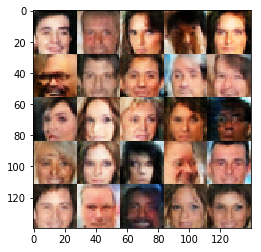

Epoch 3/3... Discriminator Loss: 1.4182... Generator Loss: 0.7190
Epoch 3/3... Discriminator Loss: 1.4457... Generator Loss: 0.6471
Epoch 3/3... Discriminator Loss: 1.4383... Generator Loss: 0.7297
Epoch 3/3... Discriminator Loss: 1.4728... Generator Loss: 0.6648
Epoch 3/3... Discriminator Loss: 1.4043... Generator Loss: 0.7644


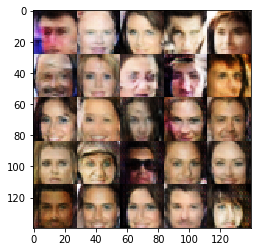

Epoch 3/3... Discriminator Loss: 1.4031... Generator Loss: 0.7430
Epoch 3/3... Discriminator Loss: 1.4323... Generator Loss: 0.7481
Epoch 3/3... Discriminator Loss: 1.4074... Generator Loss: 0.7024
Epoch 3/3... Discriminator Loss: 1.4783... Generator Loss: 0.6281
Epoch 3/3... Discriminator Loss: 1.4444... Generator Loss: 0.6322


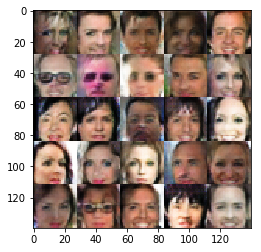

Epoch 3/3... Discriminator Loss: 1.4370... Generator Loss: 0.7132
Epoch 3/3... Discriminator Loss: 1.4456... Generator Loss: 0.7494
Epoch 3/3... Discriminator Loss: 1.4360... Generator Loss: 0.7170
Epoch 3/3... Discriminator Loss: 1.4427... Generator Loss: 0.7027
Epoch 3/3... Discriminator Loss: 1.4151... Generator Loss: 0.7900


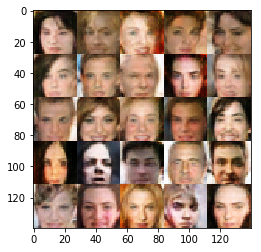

Epoch 3/3... Discriminator Loss: 1.4670... Generator Loss: 0.7306
Epoch 3/3... Discriminator Loss: 1.4014... Generator Loss: 0.7212
Epoch 3/3... Discriminator Loss: 1.4367... Generator Loss: 0.7077
Epoch 3/3... Discriminator Loss: 1.4297... Generator Loss: 0.7425
Epoch 3/3... Discriminator Loss: 1.4446... Generator Loss: 0.6470


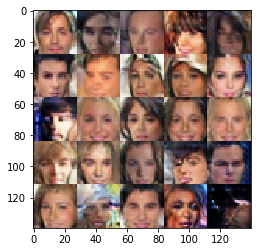

Epoch 3/3... Discriminator Loss: 1.4215... Generator Loss: 0.6952
Epoch 3/3... Discriminator Loss: 1.4526... Generator Loss: 0.7769
Epoch 3/3... Discriminator Loss: 1.3877... Generator Loss: 0.6910
Epoch 3/3... Discriminator Loss: 1.4637... Generator Loss: 0.6074
Epoch 3/3... Discriminator Loss: 1.4365... Generator Loss: 0.7346


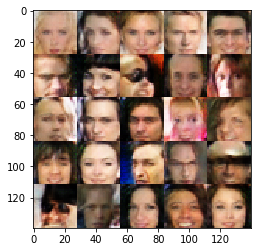

Epoch 3/3... Discriminator Loss: 1.4172... Generator Loss: 0.7607
Epoch 3/3... Discriminator Loss: 1.4603... Generator Loss: 0.7576
Epoch 3/3... Discriminator Loss: 1.4561... Generator Loss: 0.6748
Epoch 3/3... Discriminator Loss: 1.4415... Generator Loss: 0.7030
Epoch 3/3... Discriminator Loss: 1.4444... Generator Loss: 0.6606


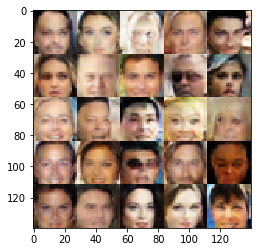

Epoch 3/3... Discriminator Loss: 1.4146... Generator Loss: 0.7370
Epoch 3/3... Discriminator Loss: 1.4330... Generator Loss: 0.7026
Epoch 3/3... Discriminator Loss: 1.4045... Generator Loss: 0.7156
Epoch 3/3... Discriminator Loss: 1.4613... Generator Loss: 0.6492
Epoch 3/3... Discriminator Loss: 1.3956... Generator Loss: 0.8290


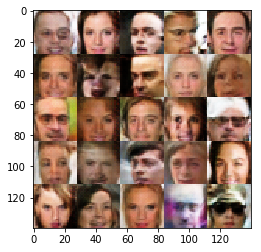

Epoch 3/3... Discriminator Loss: 1.4293... Generator Loss: 0.7033
Epoch 3/3... Discriminator Loss: 1.3781... Generator Loss: 0.7142
Epoch 3/3... Discriminator Loss: 1.4249... Generator Loss: 0.7362
Epoch 3/3... Discriminator Loss: 1.4220... Generator Loss: 0.8406
Epoch 3/3... Discriminator Loss: 1.4091... Generator Loss: 0.7257


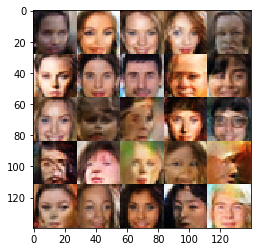

Epoch 3/3... Discriminator Loss: 1.4235... Generator Loss: 0.7059
Epoch 3/3... Discriminator Loss: 1.4345... Generator Loss: 0.6240
Epoch 3/3... Discriminator Loss: 1.4281... Generator Loss: 0.7954
Epoch 3/3... Discriminator Loss: 1.4205... Generator Loss: 0.7322
Epoch 3/3... Discriminator Loss: 1.3958... Generator Loss: 0.8179


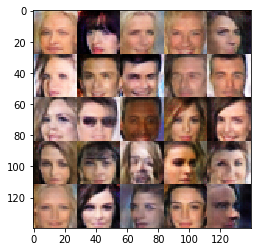

Epoch 3/3... Discriminator Loss: 1.4243... Generator Loss: 0.6846
Epoch 3/3... Discriminator Loss: 1.4333... Generator Loss: 0.7673
Epoch 3/3... Discriminator Loss: 1.4179... Generator Loss: 0.6772
Epoch 3/3... Discriminator Loss: 1.4095... Generator Loss: 0.7169
Epoch 3/3... Discriminator Loss: 1.4204... Generator Loss: 0.6649


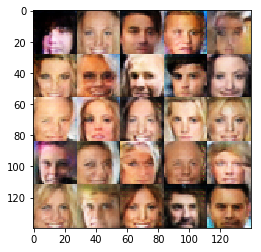

Epoch 3/3... Discriminator Loss: 1.4466... Generator Loss: 0.7210
Epoch 3/3... Discriminator Loss: 1.4536... Generator Loss: 0.6846
Epoch 3/3... Discriminator Loss: 1.4421... Generator Loss: 0.7535
Epoch 3/3... Discriminator Loss: 1.4565... Generator Loss: 0.6390
Epoch 3/3... Discriminator Loss: 1.3978... Generator Loss: 0.6478


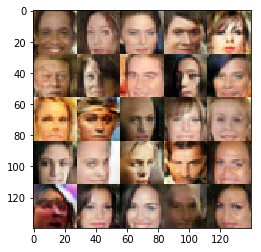

Epoch 3/3... Discriminator Loss: 1.4637... Generator Loss: 0.6972
Epoch 3/3... Discriminator Loss: 1.4415... Generator Loss: 0.7110
Epoch 3/3... Discriminator Loss: 1.4032... Generator Loss: 0.8581
Epoch 3/3... Discriminator Loss: 1.4141... Generator Loss: 0.7666
Epoch 3/3... Discriminator Loss: 1.4255... Generator Loss: 0.6500


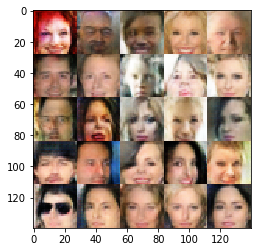

Epoch 3/3... Discriminator Loss: 1.4479... Generator Loss: 0.6618
Epoch 3/3... Discriminator Loss: 1.4314... Generator Loss: 0.6484
Epoch 3/3... Discriminator Loss: 1.4035... Generator Loss: 0.7970
Epoch 3/3... Discriminator Loss: 1.4600... Generator Loss: 0.6516
Epoch 3/3... Discriminator Loss: 1.4090... Generator Loss: 0.7459


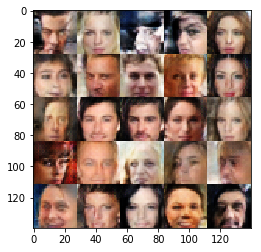

Epoch 3/3... Discriminator Loss: 1.4251... Generator Loss: 0.6903
Epoch 3/3... Discriminator Loss: 1.4670... Generator Loss: 0.7180
Epoch 3/3... Discriminator Loss: 1.4231... Generator Loss: 0.7367
Epoch 3/3... Discriminator Loss: 1.3961... Generator Loss: 0.7395
Epoch 3/3... Discriminator Loss: 1.4396... Generator Loss: 0.6890


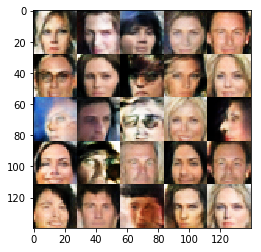

Epoch 3/3... Discriminator Loss: 1.4514... Generator Loss: 0.6490
Epoch 3/3... Discriminator Loss: 1.3963... Generator Loss: 0.7724
Epoch 3/3... Discriminator Loss: 1.4440... Generator Loss: 0.6619
Epoch 3/3... Discriminator Loss: 1.4040... Generator Loss: 0.7140
Epoch 3/3... Discriminator Loss: 1.4421... Generator Loss: 0.6740


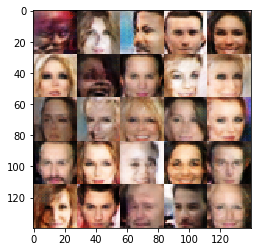

Epoch 3/3... Discriminator Loss: 1.4438... Generator Loss: 0.7923
Epoch 3/3... Discriminator Loss: 1.3990... Generator Loss: 0.6676
Epoch 3/3... Discriminator Loss: 1.3816... Generator Loss: 0.7866
Epoch 3/3... Discriminator Loss: 1.4166... Generator Loss: 0.7206
Epoch 3/3... Discriminator Loss: 1.4858... Generator Loss: 0.6108


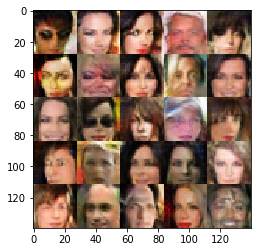

Epoch 3/3... Discriminator Loss: 1.3987... Generator Loss: 0.7235
Epoch 3/3... Discriminator Loss: 1.4496... Generator Loss: 0.6465
Epoch 3/3... Discriminator Loss: 1.4359... Generator Loss: 0.7416
Epoch 3/3... Discriminator Loss: 1.4343... Generator Loss: 0.7053
Epoch 3/3... Discriminator Loss: 1.4450... Generator Loss: 0.6596


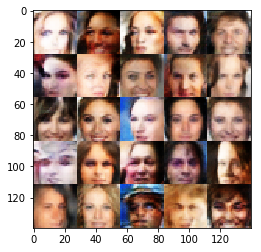

Epoch 3/3... Discriminator Loss: 1.4042... Generator Loss: 0.7403
Epoch 3/3... Discriminator Loss: 1.4170... Generator Loss: 0.7571
Epoch 3/3... Discriminator Loss: 1.4209... Generator Loss: 0.6969
Epoch 3/3... Discriminator Loss: 1.4170... Generator Loss: 0.6898
Epoch 3/3... Discriminator Loss: 1.4231... Generator Loss: 0.6877


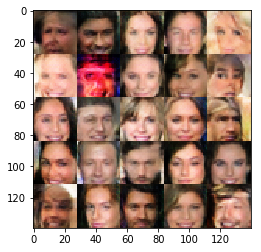

Epoch 3/3... Discriminator Loss: 1.4289... Generator Loss: 0.6518
Epoch 3/3... Discriminator Loss: 1.4388... Generator Loss: 0.6714
Epoch 3/3... Discriminator Loss: 1.5003... Generator Loss: 0.6293
Epoch 3/3... Discriminator Loss: 1.4283... Generator Loss: 0.7273
Epoch 3/3... Discriminator Loss: 1.4456... Generator Loss: 0.7871


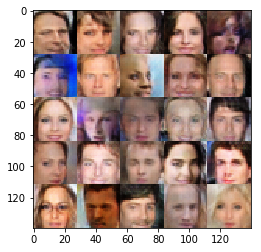

Epoch 3/3... Discriminator Loss: 1.3710... Generator Loss: 0.8136
Epoch 3/3... Discriminator Loss: 1.4955... Generator Loss: 0.7285
Epoch 3/3... Discriminator Loss: 1.4594... Generator Loss: 0.6984
Epoch 3/3... Discriminator Loss: 1.4421... Generator Loss: 0.6533
Epoch 3/3... Discriminator Loss: 1.4315... Generator Loss: 0.7548


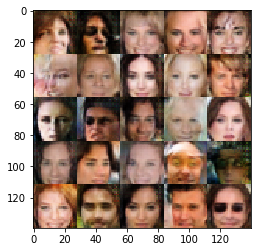

Epoch 3/3... Discriminator Loss: 1.4051... Generator Loss: 0.7471
Epoch 3/3... Discriminator Loss: 1.4211... Generator Loss: 0.6877
Epoch 3/3... Discriminator Loss: 1.4410... Generator Loss: 0.6788
Epoch 3/3... Discriminator Loss: 1.4241... Generator Loss: 0.7263
Epoch 3/3... Discriminator Loss: 1.4477... Generator Loss: 0.6175


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.